In [506]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [507]:
df = pd.read_pickle("./datos/estandarizados.pkl")
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,4,0,1,1,1,0,2,-0.778781,-0.632082,1.232734,-0.391485,-0.771840,654,-1.802458
1,2,4,0,1,0,2,1,2,-0.674240,-0.691755,0.469324,0.731665,-1.155857,670,-1.901181
2,3,4,0,1,0,3,1,1,-1.580704,-1.692801,-1.331685,0.729762,-1.176978,1229,-1.607158
3,4,4,0,1,0,4,1,1,-1.560855,-1.553969,-0.266251,-0.393388,-1.200019,1454,-1.492876
4,5,4,0,1,0,5,1,1,-1.413968,-1.450455,-1.333773,-0.054540,-1.249941,1518,-1.472487


## encoding get dummies para season

In [508]:
season_cambio = {2:3, 1:2, 3:1, 4:0}

In [509]:
df["season"]=df["season"].map(season_cambio)

## encoding para weekday

In [510]:
dummies_dia = pd.get_dummies(df["weekday"], prefix_sep = "_", prefix = "dia", dtype = int)
dummies_dia

,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
681,0,0,0,0,0,1,0
682,0,0,0,0,0,0,1
683,1,0,0,0,0,0,0
684,0,1,0,0,0,0,0


In [511]:
df= pd.concat([df, dummies_dia], axis = 1)
df.drop('weekday', axis=1, inplace= True)

In [512]:
df.head(2)

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,...,casual,registered,cnt,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6,dia_7
0,1,0,0,1,1,0,2,-0.778781,-0.632082,1.232734,...,-0.771840,654,-1.802458,1,0,0,0,0,0,0
1,2,0,0,1,0,1,2,-0.674240,-0.691755,0.469324,...,-1.155857,670,-1.901181,0,1,0,0,0,0,0


In [513]:
columnas_categoria = ["instant", "yr", "holiday", "workingday", "weathersit"]

for i in columnas_categoria:
    df[i] = df[i].astype("category")

# Decision Tree

Decision tree que sale por defecto (sin tocar los hiperparámetros)

Separamos X e y

In [514]:
X = df.drop(["registered", "cnt", "instant", "atemp", "mnth"], axis = 1)
y = df["registered"]

train test split

In [515]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

modelo

In [516]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [517]:
#fig = plt.figure(figsize = (10,6))
#tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
#plt.show()

Hiperparámetros

In [518]:
max_features = np.sqrt(len(x_train.columns))
max_features

4.0

In [519]:
# max depth

print(arbol.tree_.max_depth)

22


In [520]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

metricas

In [521]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [522]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,591.514493,722888.586957,850.22855,0.711165,test,Decission Tree I
1,0.000000,0.000000,0.00000,1.000000,train,Decission Tree I


Decision tree que sale por defecto tocando los hiperparámetros

In [523]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]}

In [524]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [525]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [526]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10, random_state=42)

In [527]:
# # veamos ahora que pinta tiene nuestro árbol


# fig = plt.figure(figsize=(40, 20))
# tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [528]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [529]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,821.736279,1.216610e+06,1103.000268,0.513896,test,Decision tree II
1,667.736579,7.066867e+05,840.646618,0.714169,train,Decision tree II


In [530]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,591.514493,7.228886e+05,850.228550,0.711165,test,Decission Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decission Tree I
0,821.736279,1.216610e+06,1103.000268,0.513896,test,Decision tree II
1,667.736579,7.066867e+05,840.646618,0.714169,train,Decision tree II


In [531]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
8,casual,0.557026
1,yr,0.204318
0,season,0.074516
9,dia_1,0.052806
5,temp,0.048126
10,dia_2,0.042408
7,windspeed,0.008731
3,workingday,0.006639
6,hum,0.003334
11,dia_3,0.002043


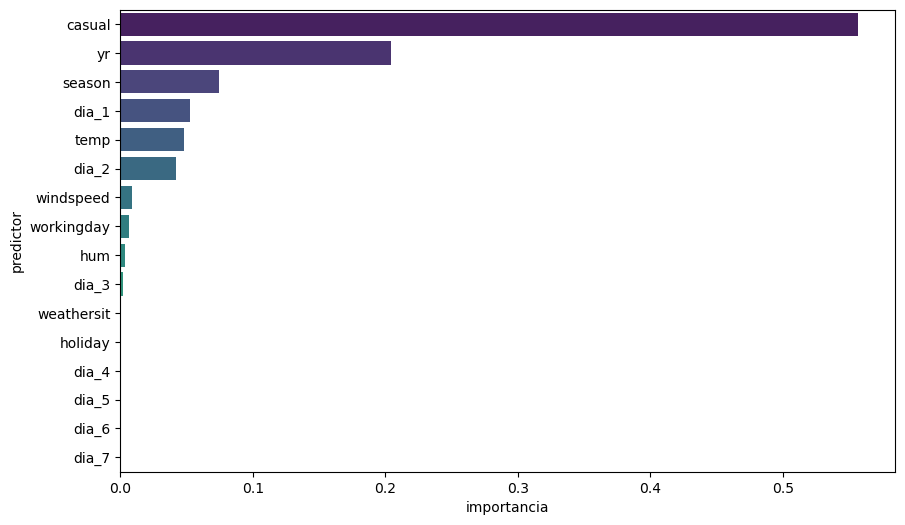

In [532]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()